In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import src.iodata as iodata
#import src.preprocess as preproc
#import src.markovchain as mchain
#import src.visualize as visualize

## TODO:
### source data
- specify anchor as global/input
- if files not in local cache, use GVT s3utils for downloading from public Bitmex.
- refactor out code to sep file.

### strategy
- Look at df_bbo_imb dataframe instead of aggregated df_bbo, if imbalance/Microprice (=Pr of jump) outside some bounds, cancel LOs if needed.

# XBTUSD

# Experimental

## Combine Trades With Quotes

In [2]:
# ========================
# ==== Get Trade Data ====
# ========================
import pickle, dateutil
src = r"C:\Users\Pontus\Documents\GitHub\microprice\20210403_trade.csv.gz"
iter_csv = pd.read_csv(src, iterator=True, chunksize=100000, compression='gzip')
df_trds = pd.concat([chunk[chunk['symbol'] == 'XBTUSD'] for chunk in iter_csv])
#df0.drop(inplace=True, columns=['symbol'])
df_trds = df_trds[['timestamp', 'side', 'size','price','tickDirection']]
df_trds['timestamp'] = df_trds['timestamp'].map(dateutil.parser.isoparse)

In [3]:
# ========================
# ==== Get Quote Data ====
# ========================
ticker = 'XBTUSD'
df = iodata._get_raw_df_xbt2(ticker)
df.rename(inplace=True, columns={'askPrice':'ask', 'askSize':'as', 'bidPrice':'bid', 'bidSize':'bs'})
df = iodata._extend_fields(df)
# Time resolution is 1ms, so duplicate might occur, keep last.
df = df[~df.index.duplicated(keep='last')]
#df['time'] = df['time'].dt.tz_localize(None)
#df.index = df.index.tz_localize(None)

def make_imb_bkt(T, n_imb):
    low_edge = np.amin([T['imb'].min(), 1.0-T['imb'].max()])
    edges = np.linspace(low_edge, 1.0 - low_edge, n_imb + 1)
    T['imb_bucket'], bins = pd.cut(T['imb'], edges, include_lowest=True, retbins=True, labels=False)
    return T

df = make_imb_bkt(df, 10)
#tmp_agg = tmp.groupby(['imb_bucket']).agg({'sizeBuy':['mean', 'std'], 'sizeSell':['mean', 'std']}).astype(int)
#tmp_agg

In [4]:
# ========================
# = Merge MO with quotes =
# ========================
import numba
@numba.njit
def assign_bucket(trdTime, quoteTime):
    out = np.empty(len(trdTime), dtype='int')
    i1 = 0
    i2 = 0
    while i1 < len(trdTime) and i2 < len(quoteTime)-1:
        if trdTime[i1] == quoteTime[i2]: # MO triggering quote update
            out[i1] = i2-1
            i1 += 1
        elif trdTime[i1] > quoteTime[i2]:
            if trdTime[i1] < quoteTime[i2+1]:
                out[i1] = i2
                i1 += 1
            else:
                i2 += 1
        else:
            out[i1] = -1
            i1 += 1
    out[i1::] = -1
    return out
            
    
def merge_quote_trade(df_trds, df_quotes):
    trades, quotes = df_trds.copy(), df_quotes.copy()
    # Find alignment
    buckets = assign_bucket(trades['timestamp'].to_numpy(),
                            quotes['timestamp'].to_numpy())
    trades['lob_bkt'] = buckets
    quotes['lob_bkt'] = np.arange(df.shape[0])
    assert (buckets == -1).sum() == 0, 'Some trades has missing quote alignment.'
    #df_trds = df_trds[df_trds['lob_bkt'] > -1]

    # Merge trades into quotes.
    trds_agg = trades.groupby(['lob_bkt', 'side']).agg({'size':['sum', 'count']}).unstack('side').fillna(0)
    trds_agg.columns = trds_agg.columns.map(''.join)
    trds_agg.rename(inplace=True, columns={'sizesumBuy':'moBuySum', 'sizecountBuy':'moBuyCnt', 'sizesumSell':'moSellSum', 'sizecountSell':'moSellCnt'})

    lb, ub  = trds_agg.index.min(), trds_agg.index.max() - 1 # remove open ended tail
    df_mgd = pd.merge(quotes, trds_agg, left_on='lob_bkt', right_index=True, how='left')
    df_mgd = df_mgd[(lb <= df_mgd['lob_bkt']) & (df_mgd['lob_bkt'] <= ub)]
    fillna_cols = ['moBuySum', 'moBuyCnt', 'moSellSum', 'moSellCnt']
    df_mgd[fillna_cols] = df_mgd[fillna_cols].fillna(value=0.0)
    df_mgd.reset_index(inplace=True, drop=True)
    return df_mgd

In [5]:
# Merge and align MO (trades) into quotes.
df_bbo_imb = merge_quote_trade(df_trds, df)

### Check distribution of MO

moBuySum                         moSellSum                        
              count  mean     mu_std    std     count  mean     mu_std    std
imb_bucket                                                                   
0            230150   129  18.774772   9007    230150  2069  68.945749  33076
1            130776   262  39.985660  14460    130776  2380  72.010136  26041
2            105597   473  53.997927  17547    105597  2065  81.786226  26577
3             97655   720  95.597412  29874     97655  1650  84.522141  26413
4             86589  1168  87.276532  25682     86589  1227  88.010576  25898
5             89065  1279  81.661963  24371     89065  1074  82.201439  24532
6             94332  1565  83.350929  25600     94332   691  57.613074  17695
7            108715  1861  74.111462  24436    108715   540  56.972656  18785
8            130769  2195  82.915776  29984    130769   303  46.789452  16920
9            252034  1652  37.364310  18758    252034   139  17.200171   8635

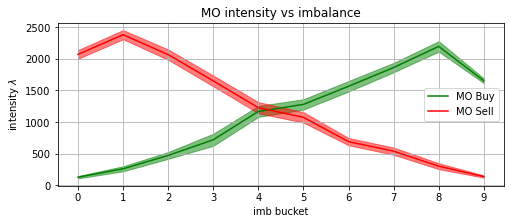

In [6]:
tmp_agg = df_bbo_imb.groupby(['imb_bucket']).agg({'moBuySum':['mean', 'std', 'count'], 'moSellSum':['mean', 'std', 'count']}).astype(int)
tmp_agg.loc[:,( 'moBuySum', 'mu_std')] = tmp_agg[( 'moBuySum', 'std')] / np.sqrt(tmp_agg[( 'moBuySum', 'count')])
tmp_agg.loc[:,( 'moSellSum', 'mu_std')] = tmp_agg[( 'moSellSum', 'std')] / np.sqrt(tmp_agg[( 'moSellSum', 'count')])
tmp_agg.sort_index(axis=1, inplace=True)


fig, axs = plt.subplots(1,1, figsize=(8,3))
axs.set_title('MO intensity vs imbalance'); axs.set_xlabel('imb bucket'); axs.set_ylabel('intensity $\lambda$')
mu, mu_std = tmp_agg[('moBuySum', 'mean')], tmp_agg[('moBuySum', 'mu_std')]
axs.plot(mu, color='g', label='MO Buy')
axs.fill_between( mu.index, (mu - mu_std).clip(0), mu + mu_std, alpha=0.5, color='g')
mu, mu_std = tmp_agg[('moSellSum', 'mean')], tmp_agg[('moSellSum', 'mu_std')]
axs.plot(mu, color='r', label='MO Sell')
axs.fill_between( mu.index, (mu - mu_std).clip(0), mu + mu_std, alpha=0.5, color='r')
axs.grid()
axs.legend()
axs.set_xticks(range(10))
tmp_agg

### Downsampled: (bid, ask, imb) -> (bid,ask)
#### Each row represent a change in BBO prices 

In [7]:
# ============================================
# = Downsample: (bid, ask, imb) -> (bid,ask) =
# ==== each state repr a change in BBO ========
# Tag where quotes changes
df_bbo_imb['bb_id'] = (df_bbo_imb['bid'].diff() != 0.0).cumsum().astype(int)
df_bbo_imb['bo_id'] = (df_bbo_imb['ask'].diff() != 0.0).cumsum().astype(int)
df_bbo_imb['bbo_id'] = ((df_bbo_imb['bid'].diff() != 0.0) | (df_bbo_imb['ask'].diff() != 0.0)).cumsum().astype(int)
# BB and trades until changed.
look_at = 'bbo_id'
def collapse(x):
    x['time']
df_bbo = df_bbo_imb.groupby([look_at]).agg({'time':'first', 'moSellSum':'sum', 'moBuySum':'sum','bid':'first', 'bs':'first', 'ask':'first', 'as':'first', 'imb':'first', 'imb_bucket': 'first', 'mid':'first', 'sprd':'first'})

#### Statistics of making the spread before change in quotes

In [8]:
df_bbo['bidTurnover'] = df_bbo['moSellSum'] / df_bbo['bs']
df_bbo['askTurnover'] = df_bbo['moBuySum'] / df_bbo['as']
print(f"E(BidTurnover) = {df_bbo['bidTurnover'].mean():.2f}")
print(f"P(BidTurnover=0) = {(df_bbo['bidTurnover']==0).mean():.2f}")
print(f"E(BidTurnover|>0) = {df_bbo[df_bbo['bidTurnover']>0]['bidTurnover'].mean():.2f}")
print('')
print(f"E(AskTurnover) = {df_bbo['askTurnover'].mean():.6f}")
print(f"P(AskTurnover=0) = {(df_bbo['askTurnover']==0).mean():.2f}")
print(f"E(AskTurnover|>0) = {df_bbo[df_bbo['askTurnover']>0]['askTurnover'].mean():.2f}")
print('')
print(f"P(Making bid) = { ((df_bbo['bidTurnover'] > 1)).mean():.2f}")
print(f"P(Making ask) = { ((df_bbo['askTurnover'] > 1)).mean():.2f}")
print(f"P(Making sprd = making bid + ask) = { ((df_bbo['askTurnover'] >= 1) & (df_bbo['bidTurnover'] >= 1)).mean():.2f}")

E(BidTurnover) = 234.08
P(BidTurnover=0) = 0.66
E(BidTurnover|>0) = 688.79

E(AskTurnover) = 114.267028
P(AskTurnover=0) = 0.69
E(AskTurnover|>0) = 364.76

P(Making bid) = 0.19
P(Making ask) = 0.17
P(Making sprd = making bid + ask) = 0.03


#### PnL from LO at BBO,
Immediately after a change in BBO prices (bidPrice,askPrice), we either insert unit LO
- at end of both queues BB + BO,
- or at end of BB,
- or at end of BO.
Calculate Expected Pnl for each of these cases at next mid price move.

_TODO: cancel the order if imbalance changes too much._

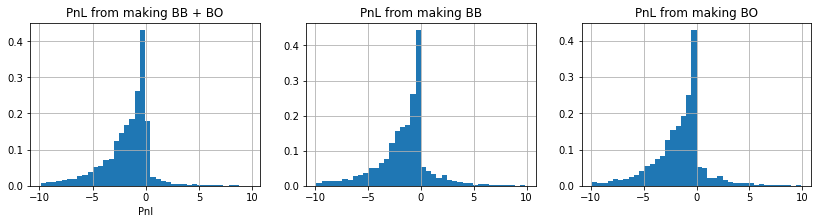

In [9]:
df_bbo['next_dBid'] = df_bbo['bid'].diff().shift(-1)
df_bbo['next_dAsk'] = df_bbo['ask'].diff().shift(-1)
df_bbo['next_dMid'] = df_bbo['mid'].diff().shift(-1)

pr_b1a1 = (df_bbo['bidTurnover'] >=1) & (df_bbo['askTurnover'] >=1)
pr_b1a0 = (df_bbo['bidTurnover'] >=1) & (df_bbo['askTurnover'] <1)
pr_b0a1 = (df_bbo['bidTurnover'] <1) & (df_bbo['askTurnover'] >=1)
pr_b0a0 = (df_bbo['bidTurnover'] <1) & (df_bbo['askTurnover'] <1)
sprd = df_bbo['sprd']
dM = df_bbo['next_dMid']

df_bbo['next_pnl_b1a1'] = pr_b1a1*sprd + pr_b1a0*(sprd*0.5 + dM) + pr_b0a1*(sprd*0.5 - dM)
df_bbo['next_pnl_b1'] = (pr_b1a0 | pr_b1a1) * (sprd*0.5 + dM)
df_bbo['next_pnl_a1'] = (pr_b0a1 | pr_b1a1) * (sprd*0.5 - dM)

fig, axs = plt.subplots(1, 3, figsize=(14,3))
lb, ub = -10, 10
axs[0].set_title('PnL from making BB + BO'); axs[0].set_xlabel('Pnl')
axs[0].hist(df_bbo['next_pnl_b1a1'].where(lambda x : (x!=0) & (x<ub) & (x>lb)), bins=40, density=True)
axs[1].set_title('PnL from making BB')
axs[1].hist(df_bbo['next_pnl_b1'].where(lambda x : (x!=0) & (x<ub) & (x>lb)), bins=40, density=True)
axs[2].set_title('PnL from making BO')
axs[2].hist(df_bbo['next_pnl_a1'].where(lambda x : (x!=0) & (x<ub) & (x>lb)), bins=40, density=True)
for ax in axs.flatten():
    ax.grid()
plt.show()

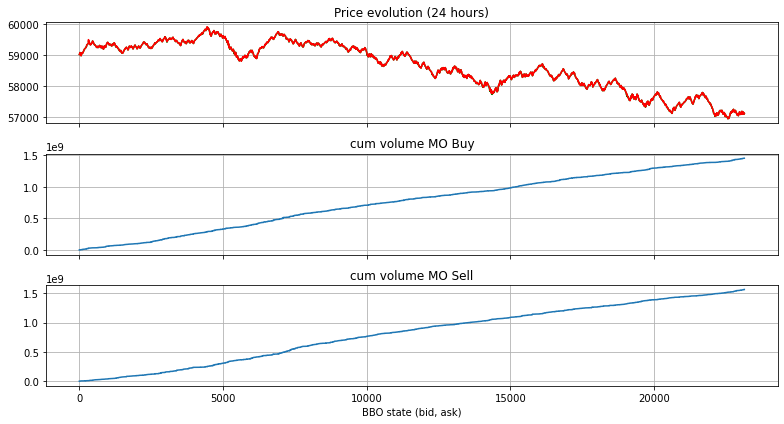

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(11,6), sharex=True)
axs[0].plot(df_bbo['bid'], color='g'); axs[0].set_title('Price evolution (24 hours)')
axs[0].plot(df_bbo['ask'], color='r')
axs[1].set_title('cum volume MO Buy')
axs[1].step(range(df_bbo.shape[0]), (df_bbo['askTurnover']*df_bbo['as']).cumsum())
axs[2].set_title('cum volume MO Sell')
axs[2].step(range(df_bbo.shape[0]), (df_bbo['bidTurnover']*df_bbo['bs']).cumsum())
axs[2].set_xlabel('BBO state (bid, ask)')

for ax in axs:
    ax.grid()
fig.tight_layout()

### Look at observation $k$:  $(bid_k, ask_k, imb_i) \forall i$

            bid      bs  moSellSum      ask      as  moBuySum
501516  59679.5       1   193764.0  59681.5  683871       0.0
501517  59679.0  306237   208928.0  59681.5  683871       0.0
501518  59679.0   97309        0.0  59681.5  683871       0.0
501519  59679.0   97309        0.0  59681.5  843871       0.0
501520  59679.0   97309    97309.0  59681.5  885266       0.0
Turnover 193764.0
PostDeltaBid = -3.0
PostDeltaAsk = 0.0


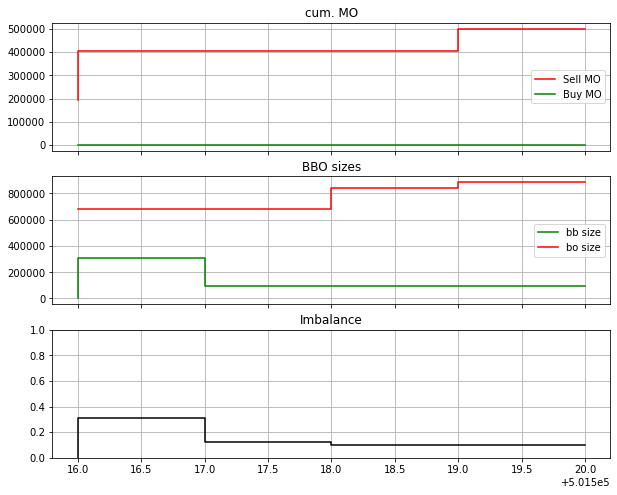

In [11]:
kth = 5
idx = df_bbo['bidTurnover'].nlargest(kth).iloc[[-1]].index[0]
inst = df_bbo['bidTurnover'].nlargest(kth).iloc[[-1]]
idx = inst.index[-1]
turnover = inst.iloc[-1]

obs = df_bbo_imb[df_bbo_imb[look_at].between(idx, idx+1)]
print(obs[['bid', 'bs', 'moSellSum', 'ask', 'as', 'moBuySum']])

fig, axs = plt.subplots(3,1, figsize=(10,8), sharex=True)
axs[0].set_title('cum. MO')
axs[0].step(obs.index, obs['moSellSum'].cumsum(), color='r', label='Sell MO')
axs[0].step(obs.index, obs['moBuySum'].cumsum(), color='g', label='Buy MO')
axs[0].legend(); axs[0].grid()

axs[1].set_title('BBO sizes')
axs[1].step(obs.index, obs['bs'], color='g', label='bb size')
axs[1].step(obs.index, obs['as'], color='r', label='bo size')
axs[1].legend(); axs[1].grid()

axs[2].set_title('Imbalance')
axs[2].step(obs.index, obs['imb'], color='k')
axs[2].set_ylim([0, 1]); axs[2].grid()


next_bid = df_bbo_imb.loc[obs.index[-1]+1]
bidChange = next_bid['bid'] - obs['bid'].iloc[0]
askChange = next_bid['ask'] - obs['ask'].iloc[0]
print(f'Turnover {turnover:.1f}')
print(f'PostDeltaBid = {bidChange}')
print(f'PostDeltaAsk = {askChange}')